In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from DS_Planck_Unet import load_planck_model, draw_pic_with_mask
from DS_healpix_fragmentation import *
from DS_data_transformation import pic2fits
import os
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
pz_model = load_planck_model(
    '/home/rt2122/Models/planck_z/f8d2.ep0014-vl0.006570-l0.004067.hdf5')
act_model = load_planck_model(
    '/home/rt2122/Models/act_cut/act_cut.ep0010-vl0.034219-l0.032022.hdf5')

In [3]:
coords = {
    #'Coma' : [194.9356, 28.0256], 
    #'Leo' : [11*15+44/4, 19+45/60], 
    #'A399' : [2*15+57/4, 13+2/60], 
    #'Shapley' : [13*15+25/4, -30],
    'pz0' : [280.308927, 30.912179],
    #'pz1' : [276.363142,30.419430], 
    #'pz2' : [273.534617,18.279171],
    #'pz3' : [265.087735,31.618461]
}
coords

{'pz0': [280.308927, 30.912179]}

In [4]:
matrs = {}
size=16
for key in coords:
    big_nside, big_pix = find_biggest_pixel(*coords[key], 500/60)
    print(big_nside)
    matr = one_pixel_fragmentation(big_nside, big_pix, 
                                   int(np.log2(2**11 / big_nside)))
    mdict = matr2dict(matr)
    x, y = mdict[radec2pix(*coords[key], 2**11)]
    matr = matr[max(0, x-size):min(x+size, matr.shape[0]-1), 
                max(y-size, 0):min(y+size, matr.shape[1] - 1)]
    matrs[key] = matr

4


In [5]:
def gen_scan_by_matr(matr, model, step=8, size=64):
    import numpy as np
    from DS_Planck_Unet import draw_pic
    from DS_data_transformation import normalize
    
    mask = np.zeros(list(matr.shape) + [1], dtype=np.float64)
    divider = np.zeros(list(matr.shape) + [1], dtype=np.float64)
    pic = normalize(draw_pic(matr))
    ypic = normalize(draw_pic(matr, y=True))
    
    st = []
    for k in range(2):
        x_st = [i for i in range(0, matr.shape[k], step) 
                if i + size <= matr.shape[k]] + [matr.shape[k] - size]
        last = matr.shape[k] - size
        if x_st[-1] != last:
            x_st.append(last)
        st.append(x_st)
    
    for x in st[0]:
        for y in st[1]:
            ans = model.predict(np.array([pic[x:x+64, y:y+64]]))[0]
            mask[x:x+64, y:y+64] += ans 
            divider[x:x+64, y:y+64] += 1
    return mask
    #return np.dstack([pic, ypic, normalize(mask / divider)])

In [6]:
pics = {}
for key in matrs:
    print(matrs[key].shape)
    pic = gen_scan_by_matr(matrs[key], pz_model)
    pics[key] = pic

(32, 32)


In [7]:
preds = {'pz14' : gen_scan_by_matr(matrs['pz0'], pz_model), 
        'pz_act10' : gen_scan_by_matr(matrs['pz0'], act_model)}

In [8]:
_, ax = plt.subplots(len(coords), 5, figsize=(16, 14))
for i, key in enumerate(coords):
    ax[i][0].set_ylabel(key)
    ax[i][0].imshow(pics[key][:,:,0]) 
    ax[i][1].imshow(pics[key][:,:,1]) 
    ax[i][2].imshow(pics[key][:,:,2]) 
    ax[i][3].imshow(pics[key][:,:,7]) #mask
    ax[i][4].imshow(pics[key][:,:,6]) #ypic
    if key == 'Leo':
        ax[i][0].set_xlabel('100')
        ax[i][1].set_xlabel('143')
        ax[i][2].set_xlabel('217')
        ax[i][3].set_xlabel('mask')
        ax[i][4].set_xlabel('y')

NameError: name 'cooords' is not defined

In [ ]:
for key in pics:
    pic2fits(pics[key], None, os.path.join('/home/rt2122/Data/cur/4pics', key + '.fits'))

In [21]:
df_pz_act = pd.read_csv(
    '/home/rt2122/Data/scans_old/scans_extended/connected/full_act_cut_ep14_thr0.1_step8.csv')
df_pz = pd.read_csv('/home/rt2122/Data/scans_old/scans_extended/connected/ep14_thr0.1_step8_nofn.csv')

In [29]:
pz_sc = SkyCoord(ra=np.array(df_pz['RA'])*u.degree, 
                 dec=np.array(df_pz['DEC'])*u.degree, frame='icrs')
pz_act_sc = SkyCoord(ra=np.array(df_pz_act['RA'])*u.degree, 
                 dec=np.array(df_pz_act['DEC'])*u.degree, frame='icrs')
thr_list = (2.5/60, 5/60, 10/60)
print('Совпадения с каталогами на расстояниях', [60 * k for k in thr_list], 'минут')
for key in coords:
    sc = SkyCoord(ra=coords[key][0]*u.degree, dec=coords[key][1]*u.degree, frame='icrs')
    print(key)
    dist = sc.separation(pz_sc).degree
    print('pz    ', [np.count_nonzero(dist < thr) for thr in thr_list])
    dist = sc.separation(pz_act_sc).degree
    print('pz_act', [np.count_nonzero(dist < thr) for thr in thr_list])

Совпадения с каталогами на расстояниях [2.5, 5.0, 10.0] минут
Coma
pz     [0, 0, 0]
pz_act [0, 0, 1]
Leo
pz     [0, 0, 1]
pz_act [0, 1, 1]
A399
pz     [0, 0, 1]
pz_act [0, 0, 0]
Shapley
pz     [0, 0, 0]
pz_act [0, 0, 0]


In [18]:
df = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz14_thr0.1_step8.csv')
df = df[df['status'] == 'tp']
df[df['catalog'] == 'planck_z'].head(10)

,RA,DEC,area,min_rad,max_rad,mean_rad,min_pred,max_pred,tRA,tDEC,status,catalog
285,280.308927,30.912179,28.0,1.869859,4.165188,3.082730,0.104544,0.988940,280.278406,30.932247,tp,planck_z
288,276.363142,30.419430,32.0,2.174412,4.240044,3.223798,0.116746,0.985809,276.336046,30.431996,tp,planck_z
293,273.534617,18.279171,33.0,1.847136,4.535301,3.284288,0.103289,0.862286,273.534871,18.292842,tp,planck_z
294,266.093042,32.971296,29.0,1.834123,4.286812,3.129741,0.106390,0.968407,266.067814,32.998643,tp,planck_z
296,265.087735,31.618461,27.0,1.980896,4.128206,3.036364,0.116430,0.939885,265.074766,31.603019,tp,planck_z
297,271.094315,16.000669,27.0,1.694091,3.784657,2.966662,0.101983,0.906578,271.069853,15.997300,tp,planck_z
298,265.918602,24.754208,51.0,1.334933,7.773043,4.416236,0.104229,0.980526,265.915475,24.740320,tp,planck_z
300,271.145530,10.049520,29.0,1.724568,4.106464,3.082174,0.135913,0.978635,271.129365,10.055297,tp,planck_z
302,263.573392,24.525294,25.0,1.516995,3.876460,2.884356,0.107331,0.967077,263.564868,24.544347,tp,planck_z
303,266.826559,17.170869,27.0,2.008170,4.383324,3.042311,0.107398,0.848759,266.804962,17.130922,tp,planck_z


In [9]:
pic, mask = draw_pic_with_mask(None, np.array([coords['pz0']]), matr=matrs['pz0'])

In [10]:
pic.shape, mask.shape

((32, 32, 6), (32, 32, 1))

In [11]:
ch = [100,143,217,353,545,857]

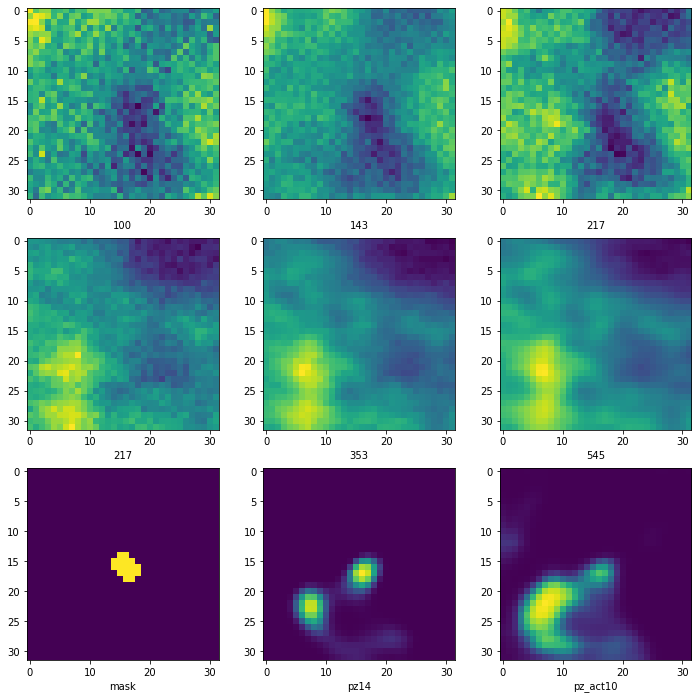

In [12]:
_, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(2):
    for j in range(3):
        ax[i][j].imshow(pic[:,:,3*i+j])
        ax[i][j].set_xlabel(ch[2*i+j])
ax[2][0].imshow(mask[:,:,0])
ax[2][0].set_xlabel('mask')
ax[2][1].imshow(preds['pz14'][:,:,0])
ax[2][1].set_xlabel('pz14')
ax[2][2].imshow(preds['pz_act10'][:,:,0])
ax[2][2].set_xlabel('pz_act10')
plt.show()